In [2]:
from fastai import *
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.callbacks.hooks import num_features_model
import cv2

In [28]:
from fastai.callbacks.hooks import num_features_model
from fastai.vision import create_head

In [3]:
from motion.detect_human import BBoxDataset

In [4]:
SZ = 500
bbox_ds = BBoxDataset("coco/val2017_one_human.csv",type = 'test', size = SZ)
bbox_ds_val =  BBoxDataset("coco/val2017_one_human.csv",type='test', size = SZ)

Dataset has 1150 samples.
Dataset has 1150 samples.


In [5]:
BS = 10

train_dl = DataLoader(bbox_ds, BS,)
valid_dl = DataLoader(bbox_ds_val, BS,)

data_bunch = DataBunch(train_dl, valid_dl)

In [11]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 1.02 * x.sigmoid_() - 0.01

In [20]:
a = torch.tensor([-10,0,0.5,1,1.3,10000])
1.02 * a.sigmoid_() -0.01

tensor([-0.0100,  0.5000,  0.6249,  0.7357,  0.7916,  1.0100])

In [12]:
learn = Learner(data_bunch, FlukeDetector(arch=models.resnet50))
learn = learn.load('fastai_bbox_detect_humans')

In [13]:
preds, targs = learn.get_preds()

In [26]:
predicted_bboxes = ((preds)*SZ ).numpy()
targets = ((targs) *SZ).numpy()
predicted_bboxes, targets

(array([[ 946.3161 ,  659.08435, 1290.9725 , 1144.4734 ],
        [ 562.82666,  788.149  ,  696.39703, 1108.3342 ],
        [ 812.83673,  577.94257, 1223.9907 , 1082.0802 ],
        [ 600.33246,  632.12836, 1266.7559 , 1346.5372 ],
        ...,
        [ 607.93005,  600.0558 ,  951.9167 , 1157.2145 ],
        [ 532.855  ,  536.1868 ,  886.368  , 1235.7761 ],
        [ 587.43616,  555.1585 , 1319.3168 , 1207.3971 ],
        [ 551.9876 ,  696.6343 ,  725.6861 , 1017.11035]], dtype=float32),
 array([[311.22968, 314.33032, 332.64645, 344.9822 ],
        [311.22968, 313.3975 , 334.20325, 344.42868],
        [311.22968, 313.33908, 334.24966, 344.3937 ],
        [313.33908, 311.22968, 344.3937 , 334.29605],
        ...,
        [311.22968, 311.8168 , 336.64703, 343.46817],
        [311.22968, 312.7544 , 335.16907, 344.04138],
        [311.22968, 313.98087, 333.26535, 344.77597],
        [311.22968, 314.85352, 331.77768, 340.10422]], dtype=float32))

In [23]:

def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        print(target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
[ 681.4527   549.85474 1072.6041  1093.3966 ]
(500, 500, 3)
[ 862.503    697.2743  1219.2283  1013.46173]
(500, 500, 3)
[ 642.4027   554.00366 1047.2941  1164.7784 ]
(500, 500, 3)
[ 640.9191   617.63     979.00934 1231.3303 ]
(500, 500, 3)
[517.47754 514.92944 831.4054  945.38605]
(500, 500, 3)
[ 500.09943  527.76196  800.3666  1252.279  ]
(500, 500, 3)
[ 569.55225  583.7819  1158.1226  1277.1489 ]
(500, 500, 3)
[ 677.60834  627.0021  1197.3689  1246.9961 ]
(500, 500, 3)
[ 708.2403   661.94885  984.134   1049.366  ]


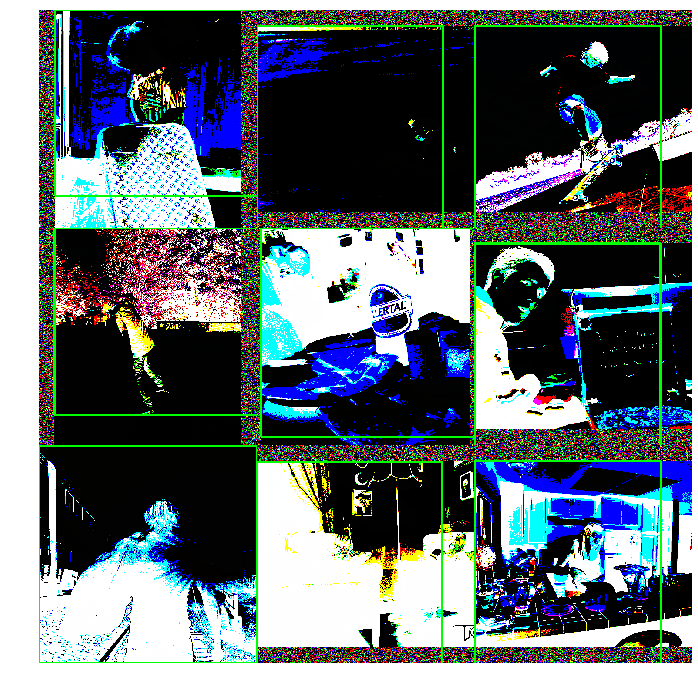

In [25]:
from skimage.util import montage
ims = np.stack([visualize(bbox_ds_val[i],target= predicted_bboxes[i]) for i in range(9,18)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

For some reason this all seems not to work how is it possible the it gives results bigger than 1 * SZ